In [1]:
from jax import config

# config.update('jax_debug_nans', True)
# config.update('jax_enable_x64', True)

In [2]:
# We need to import numpyro first, though we use it last
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro import distributions as dist

# Set the number of cores on your machine for parallelism:
cpu_cores = 4
numpyro.set_host_device_count(cpu_cores)

In [81]:
import sys
sys.path.insert(0, '../')

import matplotlib.pyplot as plt
import astropy.units as u
from frei import Planet, Grid, load_example_opacity

# Define planetary system parameters
planet = Planet.from_hot_jupiter()

lam = np.sort(np.random.uniform(1e-6, 10e-6, 100)) * u.m

# Define a grid in wavelength, pressure, and temperature; set temperature
grid = Grid(
    planet,
    lam=lam,
    n_wl_bins=30_000,     # number of wavelength bins
    n_layers=8,       # number of pressure layers
    T_ref=2400 * u.K,  # reference temperature at 0.1 bar (~T_eff)
)

# Load synthetic opacities, for demonstration purposes only
grid.load_opacities(
    opacities=load_example_opacity(grid)
);

In [82]:
# tmp = np.zeros((15, 300))
# tmp2 = np.zeros((15, 300))

# st = np.vstack([tmp, tmp2])

# st[:st.shape[0]//2, :].shape

In [83]:
# # Compute emission spectrum
# emission_result = grid.emission_spectrum(
#     # set n_timesteps>1 for iteration towards radiative equilibrium
#     n_timesteps=1
# )


In [84]:
import numpy as np
np.argmin(np.abs(grid.init_temperatures - 2000*u.K))

3

In [85]:
o = grid.opacities['1H2-16O']

In [86]:
from frei.core import F_TOA

In [87]:
# plt.loglog(grid.lam.si.value, F_TOA(grid.lam.si.value, T_star=grid.planet.T_star, a_rstar=grid.planet.a_rstar))

In [88]:
from frei.opacity import kappa
from jax import numpy as jnp


k = kappa(
    grid.opacities, grid.init_temperatures, grid.pressures, lam, planet.m_bar.si.value
)

In [89]:
# k[jnp.argmin(jnp.arange(k.shape[0])), ...].shape

In [90]:
# grid.opacities

In [91]:
n_layers = len(grid.pressures)
n_wavelengths = len(grid.lam)
fluxes_down = jnp.zeros((n_layers, n_wavelengths))# * flux_unit
fluxes_up = jnp.zeros((n_layers, n_wavelengths))# * flux_unit

from frei.twostream import emit
import numpy as np

F_toa = np.zeros_like(grid.lam.value)

opacity_grid_temperatures = jnp.linspace(
    grid.init_temperatures.si.value.min(), 
    grid.init_temperatures.si.value.max(), 
    10
)
offline_opacities = kappa(
    grid.opacities, 
    opacity_grid_temperatures, #grid.init_temperatures.si.value, 
    grid.pressures.si.value[::-1], 
    grid.lam.si.value, 
    grid.planet.m_bar.si.value
)

In [92]:
from expecto import get_spectrum

ph = get_spectrum(2300, log_g=3.0, cache=True)

In [93]:
# emission_result = np.load('example_result.txt.npy')[:, 1]

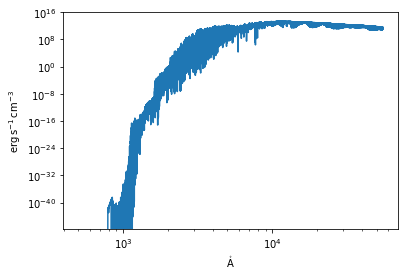

In [94]:
flux_unit_cgs = u.erg / u.s / u.cm**3
flux_unit_mks = u.W/u.m**3

from astropy.visualization import quantity_support

with quantity_support():
    # plt.loglog(grid.lam, emission_result * flux_unit_mks)
    plt.loglog(ph.wavelength, ph.flux.to(flux_unit_cgs))
# plt.xlim([0.5, 5])
# plt.ylim([1, 1e16])

In [95]:
from jax.scipy.optimize import minimize
from jax import jit

pressure_bar = jnp.array(grid.pressures.to(u.bar).value)

from functools import partial

@partial(jit, static_argnums=np.arange(1, 10))
def emit_opt(
    p, 
    pressures=grid.pressures.si.value,
    lam=grid.lam.to(u.um).value, 
    F_TOA=F_toa, 
    g=grid.planet.g.si.value,
    m_bar=grid.planet.m_bar.si.value,
    alpha=grid.planet.alpha,
    presure_bar=pressure_bar, 
    offline_opacities=offline_opacities, 
    opacity_grid_temperatures=opacity_grid_temperatures
):
    T_ref, alpha = p

    temps = T_ref * jnp.power(pressure_bar / 0.1, alpha)

    return emit(
        offline_opacities=offline_opacities, 
        temperatures=temps, 
        pressures=pressures, 
        lam=lam, 
        F_TOA=F_TOA, 
        g=g, 
        m_bar=m_bar,
        alpha=alpha,
        opacity_grid_temperatures=opacity_grid_temperatures,
    )[0][-1]

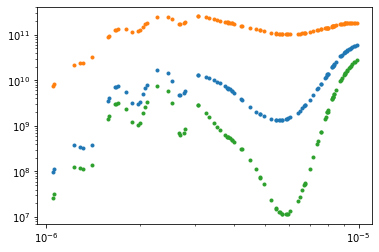

In [97]:
plt.loglog(grid.lam, emit_opt([2400., 0.2]), '.')
plt.plot(grid.lam, emit_opt([2400., 0.10]), '.')
plt.plot(grid.lam, emit_opt([3000., 0.30]), '.')

In [37]:
%%timeit
emit_opt([2400., 0.105]).block_until_ready()

38.9 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
from jax import make_jaxpr, mask

# make_jaxpr(emit_opt)([2400., 0.105])

In [39]:
example_result = np.array(emit_opt([2345., 0.1]))

In [40]:
# np.save('example_result.txt', np.vstack([grid.lam.si.value, example_result]).T)

In [41]:
y = jnp.array(emit_opt([2345.0, 0.1]))
yerr = 5e4 * jnp.sqrt(y)

In [42]:
# yerr.min()

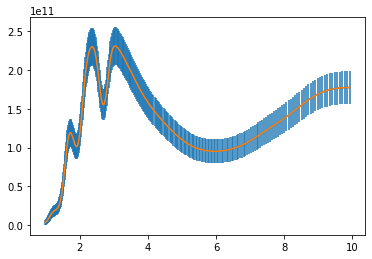

In [43]:
skip = 100
plt.errorbar(grid.lam.value[::skip], y[::skip], yerr[::skip])
plt.loglog(grid.lam[::skip], example_result[::skip], zorder=10)

In [44]:
from jax import grad

In [45]:
# np.finfo('float64').eps

In [46]:
# from frei.twostream import BB

In [47]:
# from astropy.constants import c, h, k_B

In [48]:
# temperature = 2400 * u.K
# bbf = 2 * h * c.to(u.um/u.s) ** 2 / grid.lam.to(u.um)**5 / np.expm1(h * c / (grid.lam.to(u.um) * k_B * temperature))

In [49]:
# bbf.unit.to(u.W/u.m**3)

In [151]:
# (u.W/u.um**3).to(u.W/u.m**3)

In [152]:
# BB(2400, grid.lam.to(u.um).value)

In [153]:
from jax import jit

@jit
def chi2_jax(p, y, yerr):
    return jnp.sum((emit_opt(p) - y)**2 / yerr**2)

In [154]:
# grad(chi2_jax)([2400.], y)

In [155]:
# x0 = jnp.array([2300.0, 0.11])
# result = minimize(
#     chi2_jax, x0, args=(jnp.array(y), jnp.array(yerr)), method='bfgs'
# )

In [156]:
# result

In [1]:
# from astropy.constants import h, c
# np.float32(h * c)

In [158]:
# plt.errorbar(grid.lam.value, y, yerr)
# plt.loglog(grid.lam.value, y, zorder=10)

In [50]:
def numpyro_model(yerr=yerr):
    alpha = numpyro.sample(
        'alpha', 
        dist.Uniform(low=0.08, high=0.15)
    )

    T_ref = numpyro.sample(
        'T_ref', 
        dist.Uniform(low=2000, high=3000)
    )
    
    numpyro.sample(
       'obs', 
       dist.Normal(
           loc=emit_opt([T_ref, alpha]),
           scale=yerr),
       obs=y
    )
    

In [51]:
# jnp.sum((emit_opt([2405]) - y)**2 / yerr**2)

In [52]:
# Random numbers in jax are generated like this:
from jax.random import PRNGKey, split

rng_seed = 42
rng_keys = split(
    PRNGKey(rng_seed), 
    cpu_cores
)

# Define a sampler, using here the No U-Turn Sampler (NUTS)
# with a dense mass matrix:
sampler = NUTS(
    numpyro_model, 
    # dense_mass=True
)

# Monte Carlo sampling for a number of steps and parallel chains: 
mcmc = MCMC(
    sampler, 
    num_warmup=100, 
    num_samples=500, 
    num_chains=4
)

# Run the MCMC
mcmc.run(rng_keys)

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [42]:
# mcmc.get_samples()

In [ ]:
# result = arviz.from_numpyro(mcmc)


In [64]:
a = {'a': 1, 'b': 2}

for k in a:
    print(k, a[k])

a 1
b 2


In [98]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     T_ref   2348.88     61.81   2344.77   2205.44   2349.79     17.46      1.03
     alpha      0.10      0.01      0.10      0.10      0.12      5.87      3.00

Number of divergences: 0


In [59]:
# these packages will aid in visualization:
import arviz
from corner import corner

# arviz converts a numpyro MCMC object to an `InferenceData` object based on xarray:
# result = arviz.from_numpyro(mcmc)

# these are the inputs to the synthetic double-gaussian profile (blue lines)
truths = [2345, 0.1]
# make a corner plot
corner(
    np.vstack([v for k, v in mcmc.get_samples().items()]).T, 
    quiet=True, 
    truths=truths
);

AssertionError: I don't believe that you want more dimensions than samples!

In [44]:
# from jax import numpy as jnp
# log_wavelength=np.log(grid.lam.to(u.um).value)

# @jit
# def BB(log_temp): #, log_wavelength=np.log(grid.lam.to(u.um).value)):
#     """
#     Compute the blackbody flux

#     Parameters
#     ----------
#     temperature : ~astropy.units.Quantity
#         Temperature of the blackbody

#     Returns
#     -------
#     bb : function
#         Returns a function which takes the wavelength as an
#         `~astropy.units.Quantity` and returns the Planck flux
#     """
#     h = 6.62607015e-34  # J s
#     c = 299792458.0e6  # um/s
#     k_B = 1.380649e-23  # J/K
#     temperature = jnp.exp(log_temp)
#     wavelength = np.exp(log_wavelength)

#     denom0 = jnp.where(
#         jnp.expm1(h * c / (wavelength * k_B * temperature)) == 0.0, 
#         1.0,
#         jnp.expm1(h * c / (wavelength * k_B * temperature))
#     )

#     return jnp.sum(jnp.where(
#         denom0 > 0.0,
#         1.0,
#         1e18 *  # convert microns to meters
#         2 * h * c ** 2 / denom0 / np.power(wavelength, 5)
#     ))


In [45]:
# from jax import lax 
# h = 6.62607015e-34  # J s
# c = 299792458.0e6  # um/s
# k_B = 1.380649e-23  # J/K
# # np.expm1(1)

In [46]:
# from jax import grad

# # BB(10.0), grad(BB)(10.0)

In [47]:
# def safe_f(x):
#     safe_x = jnp.where(x == 0., 1.0, x)
#     return jnp.where(
#         x == 0, 0., 1./safe_x
#     )

# x = 0.
# grad(safe_f)(x)

In [48]:
# h * c * wavenumber

In [49]:
# wavenumber

In [50]:
# # @jit
# # https://github.com/google/jax/issues/1052
# def denom(x):
#     safe_x = jnp.where(x == 0., 1.0, x)
#     return jnp.where(
#         x == 0., 0., 1./safe_x
#     )

# @jit
# def true_fun(x):
#     return 1.0 / x

# @jit
# def false_fun(x):
#     return 0.

# @jit
# def vectorized_cond(x):
#     # true_fun and false_fun must act elementwise (i.e. be vectorized)
#     true_op = jnp.where(x > 0., x, 0.5)
#     false_op = jnp.where(x > 0., 0.0, x)
#     return jnp.where(
#         x > 0., 
#         true_fun(true_op), 
#         false_fun(false_op)
#     )

# # def BB(temperature):
# #     k_B = 1.380649e-23  # J/K
# #     # print(1/(k_B * temperature))
# #     return vectorized_cond(k_B * temperature)

# @jit
# def BB(temperature):
#     denom0 = vectorized_cond(jnp.expm1(h * c / k_B * wavenumber * vectorized_cond(temperature)))
#     # print(denom0)
#     return (1e18 * # convert microns to meters
#         2 * h * c ** 2 * wavenumber ** 3 * denom0
#     )

# # BB(2400.0), grad(BB)(2400.0)

In [51]:
# # @jit 
# def vectorized_cond(pred, true_fun, false_fun, operand):
#     # true_fun and false_fun must act elementwise (i.e. be vectorized)
#     true_op = jnp.where(pred, operand, 0.5)
#     false_op = jnp.where(pred, 0, operand)
#     return jnp.where(pred, true_fun(true_op), false_fun(false_op))

# def true_fun_tmp(x): 
#     return jnp.arctan2(x, x)

# def false_fun_tmp(x):
#     return x

# def tmpfun(x):
#     return vectorized_cond(
#         x > 0.5, 
#         true_fun_tmp, 
#         false_fun_tmp,
#         x
#     )

# # no nans, even after reverting #383
# tmpfun(0.1), grad(tmpfun)(0.1)
# # tmpfun(0.0)

In [52]:

# temperature = 5000
# plt.loglog(grid.lam, 1e18 * 2 * h * c ** 2 * wavenumber ** 3 * denom(jnp.expm1(h * c * wavenumber * denom(k_B * temperature))))

In [53]:
# from jax import jacfwd, jacrev

# jacfwd(BB)(2400.0), jacrev(BB)(2400.0)

In [54]:
# h = 6.62607015e-34  # J s
# c = 299792458.0e6  # um/s
# k_B = 1.380649e-23  # J/K
# temperature = 240000
# np.expm1(h * c / (grid.lam.to(u.um).value * k_B * temperature))

In [55]:
# BB(8, np.log(grid.lam.to(u.um).value))

In [56]:
# example = BB(3003)# , np.log(grid.lam.to(u.um).value))

In [57]:
# plt.loglog(grid.lam, BB(3000.0));
# plt.loglog(grid.lam, example);

In [58]:
# log_lam = jnp.log(grid.lam.to(u.um).value)


# def chi2_test(p, yerr=1e10):
#     temp, = p
#     return jnp.sum((BB(temp) - example)**2 / yerr**2)

In [59]:
# BB(9.0, log_lam) - example

In [60]:
# minimize(chi2_test, jnp.array([2505.0]), method='bfgs')

In [61]:
# from jax import grad

# grad(BB)(jnp.log(2400.), jnp.log(grid.lam.to(u.um).value))

In [62]:
from jax.scipy.ndimage import map_coordinates
from jax import numpy as jnp
from typing import Iterable, Optional
Array = jnp.ndarray

class CartesianGrid:
    """
    Linear Multivariate Cartesian Grid interpolation in arbitrary dimensions. Based
    on ``map_coordinates``.
    Notes:
        Translated directly from https://github.com/JohannesBuchner/regulargrid/ to jax.
    """

    values: Array
    """
    Values to interpolate.
    """
    limits: Iterable[Iterable[float]]
    """
    Limits along each dimension of ``values``.
    """

    def __init__(
        self,
        limits: Iterable[Iterable[float]],
        values: Array,
        mode: str = "constant",
        cval: float = jnp.nan,
    ):
        """
        Initializer.
        Args:
            limits: collection of pairs specifying limits of input variables along
                each dimension of ``values``
            values: values to interpolate. These must be defined on a regular grid.
            mode: how to handle out of bounds arguments; see docs for ``map_coordinates``
            cval: constant fill value; see docs for ``map_coordinates``
        """
        super().__init__()
        self.values = values
        self.limits = limits
        self.mode = mode
        self.cval = cval

    def __call__(self, *coords) -> Array:
        """
        Perform interpolation.
        Args:
            coords: point at which to interpolate. These will be broadcasted if
                they are not the same shape.
        Returns:
            Interpolated values, with extrapolation handled according to ``mode``.
        """
        # transform coords into pixel values
        coords = jnp.broadcast_arrays(*coords)
        # coords = jnp.asarray(coords)
        coords = [
            (c - lo) * (n - 1) / (hi - lo)
            for (lo, hi), c, n in zip(self.limits, coords, self.values.shape)
        ]
        return map_coordinates(
            self.values, coords, mode=self.mode, cval=self.cval, order=1
        )

In [63]:
p = grid.pressures.si.value
T = grid.init_temperatures.si.value
w = grid.lam.to(u.um).value

In [64]:
limits = [
    [p.min(), p.max()], 
    [T.min(), T.max()],
    [w.min(), w.max()]
]
cg = CartesianGrid(limits, offline_opacities[::-1, ::-1, :], cval=0.)

In [65]:
coords_input = 1, 2500, w
# coords = jnp.broadcast_arrays(*coords_input)
# coords = jnp.asarray(coords)
# coords = [
#     (c - lo) * (n - 1) / (hi - lo)
#     for (lo, hi), c, n in zip(limits, coords, offline_opacities.shape)
# ]

pressure_coord = (1 - p.min()) * (p.shape[0] - 1) / (p.max() - p.min())
temperature_coord = (2400 - T.min()) * (T.shape[0] - 1) / (T.max() - T.min())
wavelength_coord = (w - w.min()) * (w.shape[0] - 1) / (w.max() - w.min())
coords = jnp.broadcast_arrays(temperature_coord, wavelength_coord)
# pressure_coord, coords[0]

In [66]:
# offline_opacities

In [67]:
# pressure_coord = 1.0 # jnp.arange(len(p)) #(jnp.log(p_1) - log_p.min()) * (log_p.shape[0] - 1) / (log_p.max() - log_p.min())
# temperature_coord = (T - opacity_grid_temperatures.min()) * (opacity_grid_temperatures.shape[0] - 1) / (opacity_grid_temperatures.max() - opacity_grid_temperatures.min())
# wavelength_coord = jnp.arange(len(w)) #(lam - lam.min()) * (lam.shape[0] - 1) / (lam.max() - lam.min())
# coords = jnp.broadcast_arrays(pressure_coord, temperature_coord[None, :, None], wavelength_coord[None, None, :])

In [68]:
# coords

In [69]:
# coords = [pressure_coord, temperature_coord, wavelength_coord]

In [70]:
%%timeit 

mc = map_coordinates(
    offline_opacities[jnp.argmin(jnp.abs(pressure_coord) - p), ::-1, :], 
    coords, mode="constant", cval=0, order=1
)

53.4 µs ± 233 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [71]:
# plt.loglog(grid.lam, mc)

In [72]:
mc = map_coordinates(
    offline_opacities[::-1, ...], coords, mode="constant", cval=0, order=1
)
mc.shape

ValueError: coordinates must be a sequence of length input.ndim, but 2 != 3

In [ ]:
# np.all(mc == 0)

***

In [53]:
from jax import numpy as jnp
import numpy as np

p = jnp.logspace(-8, 2, 10)
T = 2400. * p ** 0.1
w = jnp.linspace(0.5, 5, 10_000)

opacities = jnp.array(np.random.normal(size=(len(p), len(T), len(w))))


In [ ]:
from jax import lax

In [ ]:
# def scan(f, init, xs, length=None):
#   if xs is None:
#     xs = [None] * length
#   carry = init
#   ys = []
#   for x in xs:
#     carry, y = f(carry, x)
#     ys.append(y)
#   return carry, np.stack(ys)

# def fori_loop(lower, upper, body_fun, init_val):
#   val = init_val
#   for i in range(lower, upper):
#     val = body_fun(i, val)
#   return val

# def outer(carry, i):
#     def inner(carry, j):
#         def interp_over_T(carry, x, op=opacities[i, :, j], T=T):
#             interp_T = jnp.interp(x, T, op)
#             return carry, interp_T
#         return carry, lax.scan(interp_over_T, 0.0, T)[1]   
#     return carry, lax.scan(inner, 0.0, jnp.arange(len(w)))[1]

# lax.scan(outer, 0.0, np.arange(len(p)))[1].shape

# lax.fori_loop(0, len(w), iterate_over_press_temp, np.zeros(len(w)))

In [ ]:
i = 0 
T_1 = jnp.array([1000])
def inner(carry, j, opacities=opacities, T=T, T_1=T_1):
    def interp_over_T(carry, x, op=opacities[i, :, j], T=T, T_1=T_1):
        interp_T = jnp.interp(x, T, op)
        return carry, interp_T
    return carry, lax.scan(interp_over_T, 0.0, T_1)[1]   
double_scan = lax.scan(inner, 0.0, jnp.arange(len(w)))[1][:, 0]

In [ ]:
double_vmap = vmap(lambda i: jnp.interp(1000.0, T, opacities[0, :, i]))(jnp.arange(len(w))).T[0]

In [ ]:
from jax import pmap, devices

In [ ]:
%timeit double_scan = lax.scan(inner, 0.0, jnp.arange(len(w)))[1][:, 0]

In [ ]:
%%timeit 
double_vmap = vmap(
    lambda i: jnp.interp(1000.0, T, opacities[0, :, i]), 
)(jnp.arange(len(w))).T[0]

In [ ]:
# double_vmap == double_scan

In [ ]:
from jax import vmap


# vmap(lambda x: jnp.interp(x, T, opacities[:, :, j]))(T)


# def inner(temp, j):
#     return vmap(jnp.interp)(temp, T, opacities[:, :, j])
# inner(T[0], jnp.arange(len(w)))
#vmap(inner)(jnp.arange(len(w)))